# ECE 763 Project 01: Training Multi-Layer Perceptrons and Convoluational Neural Networks on CIFAR10


Objectives: 

- To get hands-on experiences on working with images (CIFAR10) and neural networks by implementing multi-layer perceptrons (MLPs) and convolutional neural networks (ConvNets).
- To test different regularization strategies to get the best performance out of your models.
- To investigate the limitations of using MLPs in this task, compared with ConvNets. 
- To investigate the potential risk of fitting noise of both MLPs and ConvNets.


### What to Do?

* Assume you have installed the ece763 environment. Run this notebook with that environment.
* Write your code and text for all TODOs as shown by:

```python
    # TODO: ??? points - descriptions of what to do
    raise NotImplementedError # comment it out after you write your code
```

### How to submit your solutions

* Add your NCSU ID as the postfix of the notebook filename, e.g., `Project_01_MLPs_ConvNets_twu19.ipynb`
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_01_MLPs_ConvNets_twu19_results.ipynb`), and the other with all outputs cleared (`Project_01_MLPs_ConvNets_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former.

* Late policy:  5 free late days (counted using 0.5 unit, <=6 hours as 0.5 late day, otherwise 1 later day) in total – use them in your ways; Afterwards, 25% off per day late; Not accepted after 3 late days per HW and Project. Not applicable to the final project. 
* Important Note: We will NOT accept any replacement of submission after deadline, even if you can show the time stamp of the replacement is earlier than the deadline. So, please double-check if you submit correct files.
* Academic Integrity: Students are required to comply with the university policy on academic integrity found in the Code of Student Conduct found at http://policies.ncsu.edu/policy/pol-11-35-01 
* Academic Honesty: See http://policies.ncsu.edu/policy/pol-11-35-01  for a detailed explanation of academic honesty.


## Import libraries to be Used

In [1]:
## Standard libraries
import os
import json
import math
import random
import numpy as np 
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

### Identify the system


In [2]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: Chris
Release: 5.15.146.1-microsoft-standard-WSL2
Version: #1 SMP Thu Jan 11 04:09:03 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python', '3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0', 'NVIDIA GeForce RTX 3080 Laptop GPU'),
             ('CUDA_HOME', '/usr'),
             ('NVCC', 'Cuda compilation tools, release 11.5, V11.5.119'),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.1.2'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
         

## Set Random Seeds and Devices

In [3]:
# Function for setting the seed
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    # # TODO: 2 points  - write your code below
    # raise NotImplementedError # comment it out after you write your code
    seed_rank = seed + rank
    # these functions return a generator, but do not return them for now
    # seed 
    torch.manual_seed(seed_rank)
    np.random.seed(seed_rank)
    random.seed(seed_rank)
    # if GPU, set seeds on GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_rank)
        torch.cuda.manual_seed_all(seed_rank)

        # also ensure determinism on GPU for reproducibility as it typically uses
        # stochastic functionality for efficiency
        torch.backends.cudnn.deterministic = deterministic
        # benchmarks multiple convolution algorithms and selects the fastest. Good if
        # input sizes are consistent, otherwise, it begins a new benchmark for every change
        # in the input size & may result in slower runtimes
        torch.backends.cudnn.benchmark = True

seed = 42
# seed = 3407
random_seed(seed=seed, deterministic=True)

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
# device = torch.device("cpu")
print("Using device", device)

Using device cuda:0


## Prepare Datasets (CIFAR10)

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763_proj_01"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### CIFAR10
CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. 

In [5]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

# Transformations are applied on images when we want to access them. Here, we push the images into a tensor
# and normalize the values. However, you can use more transformations, like augmentations to prevent overfitting.
# Feel free to experiment with augmentations here once you have a first running MLP, but remember to not apply
# any augmentations on the test data!
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Loading the training dataset. We need to split it into a training and validation part
main_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms, download=True)
# TODO: this generator may be a source of randomness, since we set the seed here differently than above, but also maybe not
train_set, val_set = torch.utils.data.random_split(main_dataset, [45000, 5000], generator=torch.Generator().manual_seed(seed))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms, download=True)

# Create data loaders for later
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

# classes
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

Files already downloaded and verified
Files already downloaded and verified


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot 1-batch images of the CIFAR10 training dataset:

In [6]:
start_time = time.time()
dataiter = iter(train_loader)
images, labels = next(dataiter)
end_time = time.time()
print(f"Time for loading a batch: {(end_time - start_time):6.5f}s")

Time for loading a batch: 1.99774s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


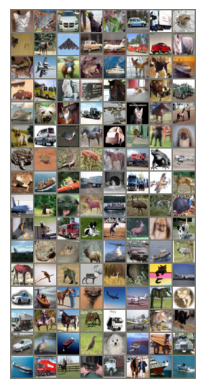

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [7]:
INV_DATA_MEANS = torch.tensor([-m for m in DATA_MEANS]).view(-1, 1, 1)
INV_DATA_STD = torch.tensor([1.0 / s for s in DATA_STD]).view(-1, 1, 1)

def imshow(img):
    img = img.div_(INV_DATA_STD).sub_(INV_DATA_MEANS) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    plt.close()


imshow(torchvision.utils.make_grid(images))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

Now we are all set. So, let's dive into implementing our own MLP and ConvNet!

## Part 0: Optimizer

To gain a better insight in the training of the neural networks, let's implement our own optimizer. First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps. 

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [8]:
class OptimizerTemplate:
    
    def __init__(self, params: nn.ParameterList, lr: float)->None:
        self.params = list(params)
        self.lr = lr
        
    def zero_grad(self)->None:
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self)->None:
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)
            
    def update_param(self, p: nn.Parameter)->None:
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD) with momentum. Plain SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

The concept of momentum replaces the gradient in the update by an exponential average of all past gradients including the current one, which allows for a smoother training. The gradient update with momentum becomes:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's implement the optimizer below:

In [9]:
class SGDMomentum(OptimizerTemplate):
    
    def __init__(self, params: nn.ParameterList, lr: float, momentum: float=0.9)->None:
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t
        
    def update_param(self, p:nn.Parameter)->None:
        # # TODO: 10 points -- Implement the gradient update
        # raise NotImplementedError
        m_t_1 = self.param_momentum[p]
        # calculate momentum for next step
        m_t = torch.multiply(self.momentum, m_t_1) + torch.multiply((1 - self.momentum), p.grad)
        # update momentum map for parameter 'p'
        self.param_momentum[p] = m_t
        # subtract in-place
        p.subtract_(torch.multiply(self.lr, m_t))
        
        

To verify that our optimizer is working, let's create a challenging surface over two parameter dimensions which we want to optimize to find the optimum:

In [10]:
def pathological_curve_loss(w1: float, w2: float) -> float:
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

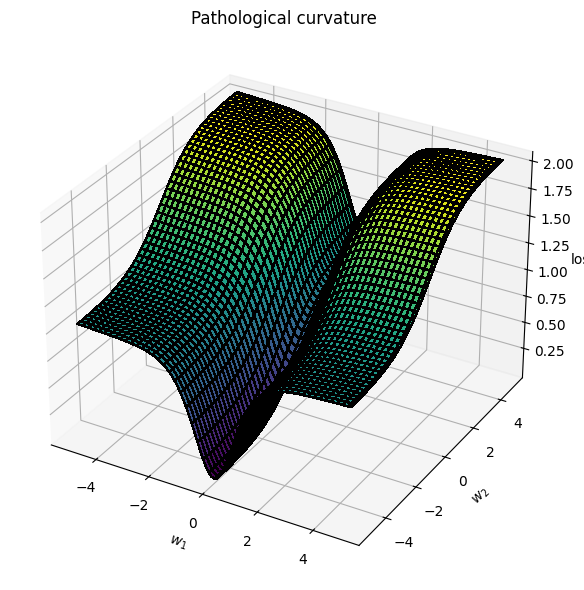

In [11]:
def plot_curve(curve_fn, x_range: Tuple[float, float] = (-5,5), y_range: Tuple[float, float]=(-5,5), plot_3d: bool=False, cmap=cm.viridis, title: str="Pathological curvature"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d") if plot_3d else fig.add_subplot()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y], indexing='ij')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [12]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing 
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])
    
    list_points = []
    for _ in range(num_updates):
        # # TODO: 8 points -- Determine the loss for the current weights, save the weights and loss, perform backpropagation
        # raise NotImplementedError
        optimizer.zero_grad()
        loss = curve_func(*weights)
        list_points.append(weights.clone())
        loss.backward()
        optimizer.step()
        
        
    points = torch.stack(list_points, dim=0).detach().cpu().numpy()
    return points

Next, let's apply the optimizer on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [13]:
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
print(SGDMom_points)

[[ 5.00000000e+00  5.00000000e+00]
 [ 4.98963690e+00  4.99335194e+00]
 [ 4.96993923e+00  4.98067713e+00]
 [ 4.94182587e+00  4.96249342e+00]
 [ 4.90611601e+00  4.93922949e+00]
 [ 4.86353874e+00  4.91123343e+00]
 [ 4.81474257e+00  4.87878084e+00]
 [ 4.76030016e+00  4.84208155e+00]
 [ 4.70071554e+00  4.80128479e+00]
 [ 4.63642836e+00  4.75648212e+00]
 [ 4.56781864e+00  4.70770979e+00]
 [ 4.49520826e+00  4.65494967e+00]
 [ 4.41886282e+00  4.59812975e+00]
 [ 4.33899117e+00  4.53712082e+00]
 [ 4.25574541e+00  4.47173405e+00]
 [ 4.16921663e+00  4.40171528e+00]
 [ 4.07942915e+00  4.32673740e+00]
 [ 3.98633361e+00  4.24638891e+00]
 [ 3.88979340e+00  4.16016054e+00]
 [ 3.78956723e+00  4.06742573e+00]
 [ 3.68528390e+00  3.96741462e+00]
 [ 3.57640553e+00  3.85917854e+00]
 [ 3.46217322e+00  3.74154282e+00]
 [ 3.34152675e+00  3.61303926e+00]
 [ 3.21297932e+00  3.47181416e+00]
 [ 3.07441831e+00  3.31549430e+00]
 [ 2.92277098e+00  3.14099097e+00]
 [ 2.75341249e+00  2.94420815e+00]
 [ 2.55904031e+00  2

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

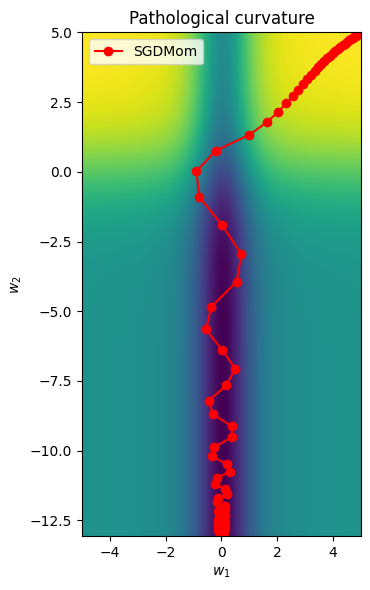

In [14]:
all_points = SGDMom_points
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="red", marker="o", zorder=2, label="SGDMom")
plt.legend()
plt.show()

If the implementation is correct, you should see that the optimizer indeed reaches a point of very low $w_2$ ($w_2 < -7.5$) and $w_1\approx 0$. If not, go back to your optimizer implementation and check what could go wrong.

## Part 1. Generic training and validation function

Now that we the optimizer implemented, and the dataset loaded, we can look at implementing our own training functions. 

In [15]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_wrapper(pred: torch.Tensor, ground_truth: torch.Tensor) -> np.ndarray:
    pred_argmax = torch.Tensor([torch.argmax(pred[i]) for i in range(len(pred))])
    return confusion_matrix(ground_truth.cpu(), pred_argmax.cpu())

In [16]:
from sklearn.preprocessing import OneHotEncoder

def check_predictions(pred: torch.Tensor, ground_truth: torch.Tensor, transform_labels_by_onehotencoder: bool = True, enc: Optional[OneHotEncoder] = None) -> Tuple[int, np.ndarray]:
    # raise NotImplementedError
    if len(pred.shape) == 1:
        pred = pred.view(-1, 1)
    n_classes: int = len(pred[0])

    C = confusion_matrix_wrapper(pred, ground_truth)
    
    if transform_labels_by_onehotencoder:
        device = ground_truth.device
        # fit ground truth to one hot encoding
        if enc is None:
            enc = OneHotEncoder(categories=[np.arange(0, n_classes)])
            enc.fit(ground_truth.view(-1, 1).cpu())
        ground_truth = torch.tensor(enc.transform(ground_truth.view(-1, 1).cpu()).toarray()).to(device)

    if pred.shape != ground_truth.shape:
        raise RuntimeError(f"Mismatched shapes between pred & ground_truth: '{pred.shape}' vs '{ground_truth.shape}'")
    
    # determine sample wise accuracy between prediction & ground-truth
    return int(
        np.sum(
            [
                int(
                    ground_truth[i, torch.argmax(pred[i])].cpu()
                ) for i in range(len(pred))
            ]
        )
    ), C

In [17]:
def train_one_epoch(model: nn.Module, optimizer: OptimizerTemplate, loss_module, data_loader)->Tuple[float, int]:

    C = np.zeros((model.num_classes, model.num_classes))
    true_preds, count = 0.0, 0
    model.train()
    enc = None
    for imgs, labels in data_loader:
        # # TODO: 10 points -- Implement training loop with training on classification
        # raise NotImplementedError
        imgs = imgs.to(device)
        labels = labels.to(device)
        if enc is None:
            enc = OneHotEncoder()
            enc.fit(np.arange(0, model.num_classes).reshape(model.num_classes, -1))
        # zero out gradients of parameters in optimizer
        optimizer.zero_grad()
        # run model forward
        out = model.forward(imgs)
        # get loss
        loss = loss_module(out, labels)
        loss.backward()
        optimizer.step()
       
        # Record statistics during training
        count += len(imgs)
        true_preds_, C_ = check_predictions(out, labels, enc=enc)
        true_preds += true_preds_
        if C.shape == C_.shape:
            C = np.add(C, C_)
        else:
            print(f"Mismatched shape for confusion matrix: '{C.shape}' vs '{C_.shape}'")
    
    train_acc = true_preds / count
    return train_acc, C

In [18]:
@torch.no_grad()
def test_model(model, data_loader) -> Tuple[float, np.ndarray]:
    # # TODO: 10 points - Test model and return accuracy
    # raise NotImplementedError

    C = np.zeros((model.num_classes, model.num_classes))
    true_preds, count = 0.0, 0
    return_to_training: bool = False
    if model.training:
        return_to_training = True
    model.eval()
    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model.forward(imgs)

        count += len(imgs)
        true_preds_, C_ = check_predictions(out, labels)
        true_preds += true_preds_
        if C.shape == C_.shape:
            C = np.add(C, C_)
        else:
            print(f"Mismatched shape for confusion matrix: '{C.shape}' vs '{C_.shape}'")
            
    if return_to_training:
        model.train()
    test_acc = true_preds / count
    return test_acc, C

In [19]:
def save_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # # TODO: 2 points -- Save the parameters of the model
    # raise NotImplementedError
    out_path = f"{root_dir}/{model_name}"
    torch.save(
        {"state_dict": model.state_dict()},
        str(out_path)
    )

def load_model(model, model_name, root_dir=CHECKPOINT_PATH):
    # # TODO: 2 points -- Load the parameters of the model
    # raise NotImplementedError
    in_path = f"{root_dir}/{model_name}"
    model.load_state_dict(torch.load(str(in_path))["state_dict"])
    model.eval()

    return model

In [20]:
def save_confusion_matrix(C: np.ndarray, out_path: str, title: Optional[str] = None):
    fig = plt.figure()
    plt.matshow(C)
    if title is not None:
        plt.title(title)
    plt.colorbar()
    plt.ylabel("True Label")
    plt.xlabel("Predicated Label")
    plt.savefig(out_path)
    plt.close()

In [21]:
def train_model(
    model,
    optimizer,
    loss_module,
    train_data_loader,
    val_data_loader,
    num_epochs=25,
    model_name="MyModel",
    plot_confusion_mat: bool = False,
    lr_epoch_map: Optional[Dict[int, float]] = None,
    test_data_loader=None,
):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs+1):
        if lr_epoch_map is not None:
            if lr_epoch_map.get(epoch) is not None:
                optimizer.lr = lr_epoch_map[epoch]
        train_acc, C = train_one_epoch(model, optimizer, loss_module, train_data_loader)
        if plot_confusion_mat:
            save_confusion_matrix(C, f"{CHECKPOINT_PATH}/confusion-mat--epoch-{epoch}.png", title=f"Training: Epoch {epoch}")

        if epoch % 5 == 0 or epoch == num_epochs:
            # Evaluate the model and save if best
            acc, C = test_model(model, val_data_loader)
            if acc > best_val_acc:
                best_val_acc = acc 
                save_model(model, model_name, CHECKPOINT_PATH)

            if plot_confusion_mat:
                save_confusion_matrix(C, f"{CHECKPOINT_PATH}/validation--confusion-mat--epoch-{epoch}.png", title=f"Validation: Epoch {epoch}")
            print(
                f"[Epoch {epoch:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )

            if test_data_loader is not None:
                acc, _ = test_model(model, test_data_loader)
                print(f"Test accuracy: {acc*100.0:05.2f}%\n")

    # Load best model after training
    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model 

## Part 2: Implementing the MLP



### Part 2.1: Vanilla MLP Module

You can make use of PyTorch's common functionalities, especially the `torch.nn` modules might be of help. The design choices of the MLP (e.g. the activation function) is left up to you, but for an initial setup, we recommend stacking linear layers with ReLU activation functions in between. Remember to not apply any activation function on the output.

In [22]:
class MLP(nn.Module):

    def __init__(self, input_dim: int=3072, num_classes: int=10, hidden_dims: List[int]=[256, 128], act_layer: nn.Module=nn.ReLU)->None:
        """
        Inputs:
            input_dim - Dimension of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_dims - A list of integers specifying the hidden layer dimensions in the MLP. 
                           The MLP should have len(hidden_sizes)+1 linear layers.
            act_layer - Activation function.
        """
        super().__init__()
        # # TODO: 5 points - Create the network based on the specified hidden sizes
        # raise NotImplementedError
        layers: List[nn.Module] = [nn.Flatten()]
        previous_dim: int = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([nn.Linear(previous_dim, hidden_dim), act_layer()])
            previous_dim = hidden_dim
        layers.append(nn.Linear(previous_dim, num_classes))

        self.layers = nn.Sequential(*layers)

        self.num_classes = num_classes
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # # TODO: 5 points -- Apply the MLP on an input
        # raise NotImplementedError
        return self.layers(x)
       

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

In [24]:
# Let's test the MLP implementation
input_dim = np.random.randint(low=64, high=3072)
num_classes = np.random.randint(low=5, high=20)
hidden_dims = [np.random.randint(low=32, high=256) for _ in range(np.random.randint(low=1, high=3))]
my_mlp = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dims=hidden_dims)
my_mlp.to(device)
random_input = torch.randn(32, input_dim, device=device)
random_output = my_mlp(random_input)
assert random_output.shape[0] == random_input.shape[0]
assert random_output.shape[1] == num_classes

In [25]:
# Create model, optimizer, and start training
model_mlp = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp.parameters(), lr=0.1) # you may tune lr
loss_module = nn.CrossEntropyLoss().to(device)

print(f'model mlp created: {count_parameters(model_mlp):05.3f}M')
model_mlp=train_model(model_mlp, optimizer, loss_module, train_loader, val_loader, num_epochs=5, model_name="myMLP_ReLU")

model mlp created: 0.821M
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch  5] Training accuracy: 57.57%, Validation accuracy: 51.86%, Best validation accuracy: 51.86%


In [26]:
# Test best model on test set
vanilla_mlp_test_acc, _ = test_model(model_mlp, test_loader)
print(f'Test accuracy: {vanilla_mlp_test_acc*100.0:05.2f}%')

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
Test accuracy: 51.17%


It is expected that you reach with the default configurations a validation and test accuracy of $\sim51-53\%$ . If you have reached this performance, we can consider this task as completed!

### Part 2.2: Improving the vanilla MLP

Now that we have a basic MLP, let's try to improve over this default performance! Your task is to think about ways to maximize the performance of your MLP. Possible suggestions you can look at include:
 
* Do data augmentations help the model to generalize?
* Can regularization techniques (dropout, weight decay, etc.) help?
* Do deeper models perform better? Or is it better to have wide networks?
* Can normalization techniques (BatchNorm, LayerNorm, etc.) help?

Your task is to improve your model to reach at least 56% on the test set! But can you get even above this? Consider this as a challenge! 

For this implementation, you can copy and then modify your codes above. List the changes that you have made and discuss what affect they have. Further, repeat the experiments for *at least 3 seeds* to report stable improvements.

In [27]:
# # TODO: 10 points -- Improve the model and list the changes as code comments. 
# # You may try different changes (e.g. those suggested above) individually or combine them. 
# # You do not need to explore all the four suggestions above.
# # You can create as many code blocks as you need. 
# raise NotImplementedError

In [28]:
import albumentations as A

def default_augmentations_albumentations():
    return A.Compose([
        A.Normalize(mean=DATA_MEANS, std=DATA_STD),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightenssContrast(p=0.2),
        A.pytorch.ToTensorV2(),
    ])

def default_augmentations_torchvision():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        # transforms.RandomApply(
        #     nn.ModuleList([
        #         transforms.CenterCrop(16),
        #     ])
        # )
        # transforms.RandomApply(
        #     nn.ModuleList([
        #         transforms.RandomPerspective(),
        #         transforms.ColorJitter(),
        #     ]), p=0.3,
        # )
    ])

In [29]:
data_transforms_ = default_augmentations_torchvision()

def seed_worker(worker_id):
    # worker_seed = torch.initial_seed() % 2**32
    random_seed(seed, deterministic=True)

# Loading the training dataset. We need to split it into a training and validation part
main_dataset_ = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms_, download=True)
# TODO: this generator may be a source of randomness, since we set the seed here differently than above, but also maybe not
train_set_, val_set_ = torch.utils.data.random_split(main_dataset_, [45000, 5000], generator=torch.Generator().manual_seed(seed))

# Loading the test set
test_set_ = CIFAR10(root=DATASET_PATH, train=False, transform=data_transforms_, download=True)

# Create data loaders for later
train_loader_ = data.DataLoader(
    train_set_,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
    worker_init_fn=seed_worker,
)
val_loader_ = data.DataLoader(
    val_set_,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    worker_init_fn=seed_worker,
)
test_loader_ = data.DataLoader(
    test_set_,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    worker_init_fn=seed_worker,
)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
class MLP(nn.Module):

    def __init__(
        self,
        input_dim: int=3072,
        num_classes: int=10,
        hidden_dims: List[int]=[256, 128],
        act_layer: nn.Module=nn.ReLU,
        do_dropout: bool = False,
        do_batch_norm: bool = False,
    )->None:
        """
        Inputs:
            input_dim - Dimension of the input images in pixels
            num_classes - Number of classes we want to predict. The output size of the MLP
                          should be num_classes.
            hidden_dims - A list of integers specifying the hidden layer dimensions in the MLP. 
                           The MLP should have len(hidden_sizes)+1 linear layers.
            act_layer - Activation function.
        """
        super().__init__()
        # # TODO: 5 points - Create the network based on the specified hidden sizes
        # raise NotImplementedError
        layers: List[nn.Module] = [nn.Flatten()]
        previous_dim: int = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            if do_dropout:  # add optional dropout
                layers.append(nn.Dropout(0.25))
            layers.append(act_layer())
            if do_batch_norm:  # add optional batch norm
                layers.append(nn.BatchNorm1d(hidden_dim))
            previous_dim = hidden_dim
        layers.append(nn.Linear(previous_dim, num_classes))
        if do_dropout:  # add optional dropout
            layers.append(nn.Dropout(0.25))
        if do_batch_norm:  # add optional batch norm
            layers.append(nn.BatchNorm1d(num_classes))

        self.layers = nn.Sequential(*layers)

        self.hidden_dims = hidden_dims
        self.do_dropout = do_dropout
        self.do_batch_norm = do_batch_norm
        self.act_func = str(act_layer)
        self.num_classes = num_classes

    def print_configuration(self):
        print(f"Number of parameters: {count_parameters(self):05.3f}M\n"
                f"Number of Hidden Dimensions: {len(self.hidden_dims)}\n"
                f"\t{self.hidden_dims}\n"
                f"Activation Function: '{self.act_func}'\n"
                f"Dropout: {self.do_dropout}\n"
                f"BatchNorm: {self.do_batch_norm}\n")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # # TODO: 5 points -- Apply the MLP on an input
        # raise NotImplementedError
        return self.layers(x)

In [31]:
skip: bool = True

if not skip:
    loss_module = nn.CrossEntropyLoss().to(device)
    
    act_layers: List[nn.Module] = [*[nn.ReLU] * 4, *[nn.ELU] * 4, *[nn.Tanh] * 4, *[nn.Hardswish] * 4]
    do_dropout_list: List[bool] = [*[False, True, False, True] * 4]
    do_batch_norm_list: List[bool] = [*[False, False, True, True] * 4]
    test_accs: List[float] = []
    
    for idx, (do_dropout, do_batch_norm, act_layer) in enumerate(zip(do_dropout_list, do_batch_norm_list, act_layers)):
        model_mlp = MLP(act_layer=act_layer, do_dropout=do_dropout, do_batch_norm=do_batch_norm).to(device)
        optimizer = SGDMomentum(model_mlp.parameters(), lr=0.1) # you may tune lr
        model_mlp.print_configuration()
        model_name = f"{idx % 4}/myMLP_{str(act_layer)}"
        os.makedirs(f"{CHECKPOINT_PATH}/{idx % 4}", exist_ok=True)
        model_mlp=train_model(model_mlp, optimizer, loss_module, train_loader, val_loader, num_epochs=5, model_name=model_name, plot_confusion_mat=False)
        test_acc, _ = test_model(model_mlp, test_loader)
        test_accs.append(test_acc)
        print(f'Test accuracy: {test_acc*100.0:05.2f}%\n\n')

    best_test_acc_idx = np.argmax(test_accs)
    best_act_layer = act_layers[best_test_acc_idx]
    do_dropout = do_dropout_list[best_test_acc_idx]
    do_batch_norm = do_batch_norm_list[best_test_acc_idx]
    print(f"Best Model:\n"
          f"\tActivation Layer: {best_act_layer}\n"
          f"\tDropout: {do_dropout}\n"
          f"\tBatch Norm: {do_batch_norm}")

In [32]:
skip: bool = True

if not skip:
    loss_module = nn.CrossEntropyLoss().to(device)
    
    act_layer = nn.Hardswish
    do_batch_norm: bool = True
    hidden_dims: List[List[int]] = [[256, 128], [256, 128, 64], [256, 128, 64, 32], [128, 64, 32], [256, 64, 32], [512, 256, 128], [1024, 512, 256, 128], [512, 256, 128, 64], [1024, 512, 256, 128, 64]]

    test_accs = []
    for idx, hidden_dim in enumerate(hidden_dims):
        model_mlp = MLP(act_layer=act_layer, hidden_dims=hidden_dim, do_batch_norm=do_batch_norm).to(device)
        optimizer = SGDMomentum(model_mlp.parameters(), lr=0.1) # you may tune lr
        model_mlp.print_configuration()
        model_name = f"{idx}/myMLP_ReLU--Hardswish--hidden-dims-{hidden_dim}"
        os.makedirs(f"{CHECKPOINT_PATH}/{idx}", exist_ok=True)
        model_mlp=train_model(model_mlp, optimizer, loss_module, train_loader, val_loader, num_epochs=5, model_name=model_name, plot_confusion_mat=False)
        test_acc, _ = test_model(model_mlp, test_loader)
        test_accs.append(test_acc)
        print(f'Test accuracy: {test_acc*100.0:05.2f}%\n\n')

    best_test_acc_idx = np.argmax(test_accs)
    best_hidden_dims = hidden_dims[best_test_acc_idx]
    print(f"Best Model:\n"
          f"\tTest accuracy: {test_accs[best_test_acc_idx] * 100:.2f}%\n"
          f"\tHidden Dimensions: {best_hidden_dims}")

In [33]:
skip: bool = True

if not skip:
    loss_module = nn.CrossEntropyLoss()

    act_layer = nn.Hardswish
    do_dropout: bool = False
    do_batch_norm: bool = True
    hidden_dims: List[int] = [1024, 512, 256, 128]
    learning_rates: List[List[float]] = [[0.1, 0.01], [0.1, 0.001], [0.1, 0.0001]]
    test_accs: List[float] = []

    for idx, lrs in enumerate(learning_rates):
        model_mlp = MLP(act_layer=act_layer, hidden_dims=hidden_dims, do_dropout=do_dropout, do_batch_norm=do_batch_norm).to(device)
        optimizer = SGDMomentum(model_mlp.parameters(), lr=lrs[0])
        model_mlp.print_configuration()
        model_name = f"{idx}/learning-rate--{lr}"
        os.makedirs(f"{CHECKPOINT_PATH}/{idx}", exist_ok=True)
        lr_epoch_map: Dict[int, float] = {8: lrs[-1]}
        model_mlp = train_model(
            model_mlp,
            optimizer,
            loss_module,
            train_loader,
            val_loader,
            num_epochs=15,
            model_name=model_name,
            plot_confusion_mat=False,
            lr_epoch_map=lr_epoch_map,
        )
        test_acc, _ = test_model(model_mlp, test_loader)
        test_accs.append(test_acc)
        print(f"Test accuracy: {test_acc*100.0:05.2f}%\n\n")

    best_test_acc_idx = np.argmax(test_accs)
    best_lr = learning_rates[best_test_acc_idx]

    print(f"Best Model:\n"
          f"\tTest Accuracy: {test_accs[best_test_acc_idx]}\n"
          f"\tLearning Rate: {best_lr}\n")

In [34]:
# Best model
hidden_dims: List[int] = [1024, 512, 256, 128]
lr_epoch_map: Dict[int, float] = {8: 0.001}
act_layer: nn.Module = nn.Hardswish
do_dropout: bool = False
do_batch_norm: bool = True
beg_lr: float = 0.1
n_epochs: int = 25

mlp_best_configuration: Dict[str, Any] = {
    "act_layer": nn.Hardswish,
    "hidden_dims": hidden_dims,
    "do_batch_norm": do_batch_norm,
    "do_dropout": do_dropout,
}

mlp_train_best_configuration: Dict[str, Any] = {
    "lr": beg_lr,
    "num_epochs": n_epochs,
    "lr_epoch_map": lr_epoch_map,
}

loss_module: nn.Module = nn.CrossEntropyLoss()

model_mlp = MLP(**mlp_best_configuration).to(device)
optimizer = SGDMomentum(model_mlp.parameters(), lr=mlp_train_best_configuration["lr"])
model_mlp.print_configuration()
model_name = "myMLP_best"
model_mlp = train_model(
    model_mlp,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=mlp_train_best_configuration["num_epochs"],
    model_name=model_name,
    plot_confusion_mat=False,
    lr_epoch_map=mlp_train_best_configuration["lr_epoch_map"],
)
test_acc, _ = test_model(model_mlp, test_loader)
print(f'Test accuracy: {test_acc*100.0:05.2f}%\n\n')

Number of parameters: 3.841M
Number of Hidden Dimensions: 4
	[1024, 512, 256, 128]
Activation Function: '<class 'torch.nn.modules.activation.Hardswish'>'
Dropout: False
BatchNorm: True

Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch  5] Training accuracy: 60.95%, Validation accuracy: 54.64%, Best validation accuracy: 54.64%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 10] Training accuracy: 75.81%, Validation accuracy: 57.56%, Best validation accuracy: 57.56%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 15] Training accuracy: 78.22%, Validation accuracy: 57.44%, Best validation accuracy: 57.56%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 20] Training accuracy: 79.46%, Validation accuracy: 57.40%, Best validation accuracy: 57.56%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 25] Training accuracy: 80.48%, Validation accuracy: 57.44%, Best validation accuracy: 57.56%
Mism

### Part 2.3: Investigating the limitations of MLP

Now that we have seen how we can optimize our MLP, it is good to investigate the limitations of the model as well. Images have a natural grid structure where close-by pixels are strongly related. Does the MLP make use of this structure? To investigate this question, we will run two experiments:
 
* Create a shuffle of pixels at the beginning of the training, and use the same shuffle throughout the training and validation.
* At each training and validation step, sample a new shuffle of pixels.
 
 
It is up to you whether you perform this investigation on the original plain MLP version or your optimized one. Implement a corresponding train and test function that support both variants of shuffling, and train two models.

In [35]:
# TODO: 2 points - create a function that shuffles pixel values of images

def change_minmax(imgs: torch.Tensor, old_minmax: Tuple[Union[int, float], Union[int, float]], new_minmax: Tuple[Union[int, float], Union[int, float]]) -> torch.Tensor:
    alpha = old_minmax[1] / new_minmax[1]
    beta = alpha * old_minmax[0] - new_minmax[0]
    return torch.subtract(torch.multiply(alpha, imgs), beta)


def generate_shuffle_idx(H: int, W: int, B: Optional[int] = None) -> torch.Tensor:
    # randomly sample between -1 & 1, as that is what 'grid_sample' uses where (-1, -1) corresponds to the top left pixel of the image
    shuffle_idx_rows = torch.FloatTensor(H, ).uniform_(-1, 1)
    shuffle_idx_cols = torch.FloatTensor(W, ).uniform_(-1, 1)
    # create grids of x & y corresponding to the indices of the pixels to shuffle
    grid_x, grid_y = torch.meshgrid(shuffle_idx_rows, shuffle_idx_cols, indexing="ij")
    # stack pixels in correct format for grid_sample
    shuffle_idx_shared = torch.stack([grid_y, grid_x], 2)
    if B is not None:
        # repeat the pixels shuffling per batch
        shuffle_idx_shared = shuffle_idx_shared.unsqueeze(0).repeat(B, 1, 1, 1)

    return shuffle_idx_shared


def shuffle_pixels(imgs: torch.Tensor, shuffle_idx_shared: Optional[torch.Tensor] = None) -> torch.Tensor:
    B, C, H, W = imgs.shape
    
    if shuffle_idx_shared is not None:
        # # shuffle the pixels using the provided shuffle idx
        # raise NotImplementedError
        if len(shuffle_idx_shared.shape) == 3 and shuffle_idx_shared.shape[-1] == 2:
            shuffle_idx_shared = shuffle_idx_shared.unsqueeze(0).repeat(B, 1, 1, 1)
        assert shuffle_idx_shared.shape == (B, H, W, 2), f"Incorrect shape: '{shuffle_idx_shared.shape}' != '{(B, H, W, 2)}'"
        imgs_max = imgs.max()
        imgs_min = imgs.min()
        if imgs_max > 1 or imgs_min < -1:
            imgs = change_minmax(imgs, old_minmax=(imgs.min(), imgs.max()), new_minmax=(-1., 1.))
    else:
        # # Sample a shuffle idx and then shuffle the pixels
        # raise NotImplementedError

        shuffle_idx_shared = generate_shuffle_idx(H=H, W=W, B=B)

    imgs = torch.nn.functional.grid_sample(imgs, shuffle_idx_shared, align_corners=False)
    
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])


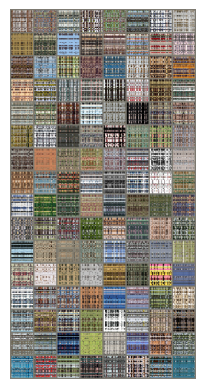

GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


In [36]:
# visualized the effects of pixel shuffle
images_pixelshuffled = shuffle_pixels(images)
print(images_pixelshuffled.shape)
imshow(torchvision.utils.make_grid(images_pixelshuffled))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

In [37]:
# Create a training and test function that supports the shuffling of pixels, either fixed and shared among the entire dataset or newly generated for each batch

def train_one_epoch_pixelshuffled(
    model: nn.Module,
    optimizer: OptimizerTemplate,
    loss_module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> Tuple[float, np.ndarray]:

    C = np.zeros((model.num_classes, model.num_classes))
    true_preds, count = 0.0, 0
    model.train()
    enc = None
    for imgs, labels in data_loader:
        # # TODO: 2 points - Implement training loop with training on classification
        # raise NotImplementedError
        imgs = shuffle_pixels(imgs, shuffle_idx_shared).to(device)
        labels = labels.to(device)
        if enc is None:
            enc = OneHotEncoder()
            enc.fit(np.arange(0, model.num_classes).reshape(model.num_classes, -1))

        optimizer.zero_grad()
        out = model.forward(imgs)
        loss = loss_module(out, labels)
        loss.backward()
        optimizer.step()

        count += len(imgs)
        true_preds_, C_ = check_predictions(out, labels, enc=enc)
        true_preds += true_preds_
        if C.shape == C_.shape:
            C = np.add(C, C_)
        else:
            print(f"Mismatched shape for confusion matrix: '{C.shape}' vs '{C_.shape}'")

        
        # Record statistics during training
    train_acc = true_preds / count
    return train_acc, C

In [38]:
@torch.no_grad()
def test_model_pixelshuffled(
    model: nn.Module,
    data_loader,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
) -> Tuple[float, np.ndarray]:
    # # TODO: 2 points -- Test model and return accuracy
    # raise NotImplementedError

    C = np.zeros((model.num_classes, model.num_classes))
    true_preds, count = 0.0, 0
    return_to_training: bool = False
    if model.training:
        return_to_training = True
    model.eval()
    for imgs, labels in data_loader:
        imgs = shuffle_pixels(imgs, shuffle_idx_shared).to(device)
        labels = labels.to(device)
        out = model.forward(imgs)

        count += len(imgs)
        true_preds_, C_ = check_predictions(out, labels)
        if C.shape == C_.shape:
            C = np.add(C, C_)
        else:
            print(f"Mismatched shape for confusion matrix: '{C.shape}' vs '{C_.shape}'")

    if return_to_training:
        model.train()
    test_acc = true_preds / count
    return test_acc, C

In [39]:
def train_model_pixelshuffled(
    model,
    optimizer,
    loss_module,
    train_data_loader,
    val_data_loader,
    num_epochs=25,
    model_name="MyMLP_pixelshuffled",
    plot_confusion_mat: bool = False,
    shuffle_idx_shared: Optional[torch.Tensor] = None,
    lr_epoch_map: Optional[Dict[int, float]] = None,
):
    # Set model to train mode
    model.to(device)
    best_val_acc = -1.0

    # Training loop
    for epoch in range(1, num_epochs + 1):
        if lr_epoch_map is not None:
            if lr_epoch_map.get(epoch) is not None:
                optimizer.lr = lr_epoch_map[epoch]
        train_acc, C = train_one_epoch_pixelshuffled(model, optimizer, loss_module, train_data_loader, shuffle_idx_shared=shuffle_idx_shared)
        if plot_confusion_mat:
            save_confusion_matrix(C, f"{CHECKPOINT_PATH}/confusion-mat--{model_name}--epoch-{epoch}.png", title=f"Training: Epoch {epoch}")
        
        if epoch % 5 == 0 or epoch == num_epochs:
            # Evaluate the model and save if best
            acc, _ = test_model_pixelshuffled(model, val_data_loader, shuffle_idx_shared=shuffle_idx_shared)
            if acc > best_val_acc:
                best_val_acc = acc
                save_model(model, model_name, CHECKPOINT_PATH)

            print(
                f"[Epoch {epoch:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )

    # Load best model after training
    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model

In [40]:
# Create model, optimizer, and start training on fixed shuffling of pixels
model_mlp_pixelshuffled_shared = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_shared.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

# # TODO: 2 points -- Create a shared: shuffle_idx
# raise NotImplementedError
_, H, W, _ = train_loader.dataset.dataset.data.shape
shuffle_idx = generate_shuffle_idx(H=H, W=W)

model_mlp_pixelshuffled_shared = train_model_pixelshuffled(
    model_mlp_pixelshuffled_shared,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_pixelshuffled_shared",
    shuffle_idx_shared=shuffle_idx,
)

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 43.94%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%


In [41]:
# Create model, optimizer, and start training on a new shuffling of pixels per batch/image
model_mlp_pixelshuffled_batch = MLP(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_mlp_pixelshuffled_batch.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

model_mlp_pixelshuffled_batch = train_model_pixelshuffled(
    model_mlp_pixelshuffled_batch,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myMLP_ReLU_pixelshuffled_batch",
    shuffle_idx_shared=None,
)

Mismatched shape for confusion matrix: '(10, 10)' vs '(6, 6)'
[Epoch  5] Training accuracy: 28.24%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%


What results do you observe? What does this tell us about the MLP being aware of the image structure? Add your results and observations below.

* TODO: 2 points -- write down your observations


**Based off of what we observed above, we can see that the MLP utilize the inherit image structure where pixels close to each other provide further information as the structure of the overall image. We can see that our training accuracy has dropped dramatically and our validation tests indicate our model is never able to properly classify the images suggesting that the model trained with the shuffled pixel images is overfitting to the structure of the shuffled pixels and not learning anything meaningful for detection in our case.**

## Part 3: Implementing the ConvNet

We will repeat the experiments in Part 2, but with a ConvNet.

### Part 3.1: Vanilla ConvNet

Let's start with a simple LeNet like ConvNet, consisting of a number of convolution blocks (e.g., two Conv+ReLU+MaxPool blocks) followed by a MLP consisting of two hidden layers.

In [42]:
class ConvNet(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        base_dims: int = 32,
        num_classes: int = 10,
        act_layer: nn.Module = nn.ReLU,
    )->None:
        super().__init__()
        # # TODO: 2 points -- write code for two Conv+ReLU+MaxPool blocks
        # raise NotImplementedError
        self.conv = nn.Sequential(
            nn.Conv2d(in_chans, out_channels=base_dims * 2, kernel_size=3),
            act_layer(),
            nn.MaxPool2d(kernel_size=5),
        )
        self.mlp = MLP(input_dim=base_dims*2, num_classes=num_classes, hidden_dims=[base_dims*4, base_dims*2], act_layer=act_layer)

        self.num_classes = 10
    
    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=(2, 3))
        x = self.mlp(x)
        return x

In [43]:
# Create model, optimizer, and start training

model_convnet = ConvNet(act_layer=nn.ReLU).to(device)
optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

print(f"model convnet created: {count_parameters(model_convnet):05.3f}M")
model_convnet = train_model(
    model_convnet,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    num_epochs=5,
    model_name="myConvNet_ReLU",
)

model convnet created: 0.019M
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch  5] Training accuracy: 41.01%, Validation accuracy: 41.34%, Best validation accuracy: 41.34%


In [44]:
# Test best model on test set
vanilla_convnet_test_acc, _ = test_model(model_convnet, test_loader)
print(f"Test accuracy: {vanilla_convnet_test_acc*100.0:05.2f}%")

Test accuracy: 41.39%


You will observe accuracy around $\sim41-43\%$, worse than the vanilla MLP. Next, we will try to address the performance issue by modifying the specifications of ConvNets.

### Part 3.2: Improving the ConvNet

Similar to Part 2.2. Please explore how to redesign your ConvNet to improve the performance.

In [45]:
# # TODO: 10 points -- Improve the model and list the changes as code comments.
# # You may try different changes (e.g. those suggested in Part 2.2) individually or combine them.
# # You do not need to explore all the four suggestions above.
# # You can create as many code blocks as you need.
# raise NotImplementedError

In [46]:
def build_convblock(
    in_channels: int,
    out_channels: int,
    conv_kernel_size: Union[int, Tuple[int, int]],
    act_layer: nn.Module,
    maxpool_kernel_size: int,
) -> List[nn.Module]:
    return [
        nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=conv_kernel_size),
        act_layer(),
        nn.MaxPool2d(kernel_size=maxpool_kernel_size),
    ]

class ConvNet(nn.Module):
    def __init__(
        self,
        test_img: torch.Tensor,
        in_chans: int = 3,
        num_classes: int = 10,
        act_layer: nn.Module = nn.ReLU,
        conv_hidden_dims: List[int] = [5, 10],
        conv_kernel_sizes: Union[int, List[Union[int, Tuple[int, int]]]] = [3, 5],
        conv_maxpool_kernel_sizes: Union[int, List[Union[int, Tuple[int, int]]]] = 3,
        mlp_act_layer: nn.Module = nn.ReLU,
        mlp_hidden_dims: List[int] = [32 * 4, 32 * 2],
        mlp_batch_norm: bool = False,
        mlp_dropout: bool = False,
    ) -> None:
        super().__init__()
        if not isinstance(conv_kernel_sizes, list):
            conv_kernel_sizes = [conv_kernel_sizes] * len(conv_hidden_dims)
        if len(conv_hidden_dims) != len(conv_kernel_sizes):
            raise RuntimeError(f"Conv Hidden Dims != Conv Kernel Sizes: '{len(conv_hidden_dims)}' != '{len(conv_kernel_sizes)}'")

        if not isinstance(conv_maxpool_kernel_sizes, list):
            conv_maxpool_kernel_sizes = [conv_maxpool_kernel_sizes] * len(conv_hidden_dims)
        if len(conv_hidden_dims) != len(conv_maxpool_kernel_sizes):
            raise RuntimeError(f"Conv Hidden Dims != Conv Maxpool Kernel Sizes: '{len(conv_hidden_dims)}' != '{len(conv_maxpool_kernel_sizes)}'")
        
        conv_layers: List[nn.Module] = []
        in_conv_channels = in_chans
        for conv_hidden_dim, conv_kernel_size, conv_maxpool_kernel_size in zip(conv_hidden_dims, conv_kernel_sizes, conv_maxpool_kernel_sizes):
            conv_layers.extend(
                build_convblock(
                    in_channels=in_conv_channels,
                    out_channels=conv_hidden_dim,
                    conv_kernel_size=conv_kernel_size,
                    act_layer=act_layer,
                    maxpool_kernel_size=conv_maxpool_kernel_size,
                )
            )
            in_conv_channels = conv_hidden_dim

        self.conv = nn.Sequential(*conv_layers)

        if len(test_img.shape) == 4:
            test_img = test_img[0, :, :, :].squeeze()
        with torch.no_grad():
            test_img = test_img.unsqueeze(0)
            test_out = self.conv_forward(test_img)
            flattened_size = int(test_out.flatten().size(dim=0))

        self.mlp = MLP(
            input_dim=flattened_size,
            num_classes=num_classes,
            hidden_dims=mlp_hidden_dims,
            act_layer=mlp_act_layer,
            do_batch_norm=mlp_batch_norm,
            do_dropout=mlp_dropout,
        )

        self.num_classes = num_classes
        self.act_layer = act_layer
        self.conv_hidden_dims = conv_hidden_dims
        self.conv_kernel_sizes = conv_kernel_sizes
        self.conv_maxpool_kernel_sizes = conv_maxpool_kernel_sizes
        self.mlp_input_size = flattened_size
        self.mlp_hidden_dims = mlp_hidden_dims

    def print_configuration(self):
        print(f"Model:\n"
              f"\tParameters: {count_parameters(self):05.3f}M\n"
              f"\tActivation Layer: {self.act_layer}\n"
              f"\tConv Hidden Dims: {self.conv_hidden_dims}\n"
              f"\tConv Kernel Sizes: {self.conv_kernel_sizes}\n"
              f"\tConv Maxpool Kernel Sizes: {self.conv_maxpool_kernel_sizes}\n"
              f"\tMLP Input Size: {self.mlp_input_size}\n"
              f"\tMLP Hidden Dims: {self.mlp_hidden_dims}\n")
        print("MLP Configuration:")
        self.mlp.print_configuration()
    
    def conv_forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=(2, 3))
        return x
    
    def forward(self, x):
        x = self.conv_forward(x)
        x = self.mlp(x)
        return x

In [47]:
skip: bool = True

if not skip:
    act_layers: List[nn.Module] = [*[nn.ReLU] * 7, *[nn.Hardswish] * 7]
    conv_hidden_dims: List[List[int]] = [[5, 10], [5, 10, 5], [5, 10, 15], [5, 10, 15, 10], [5, 10, 15, 10, 5], [30, 60], [30, 60, 30]] * 2
    conv_kernel_sizes: List[List[int]] = [[3, 5], [3, 5, 1], [3, 5, 1], [3, 5, 1, 1], [3, 5, 1, 1, 1], [3, 5], [3, 5, 1]] * 2
    conv_maxpool_kernel_sizes: List[List[int]] = [3, [3, 2, 1], [3, 2, 1], [3, 2, 1, 1], [3, 2, 1, 1, 1], [3, 2], [3, 2, 1]] * 2
    
    
    test_accs: List[float] = []
    for idx, (act_layer, conv_hidden_dim, conv_kernel_size, conv_maxpool_kernel_size) in enumerate(zip(act_layers, conv_hidden_dims, conv_kernel_sizes, conv_maxpool_kernel_sizes)):
        model_convnet = ConvNet(
            test_img=images[0],
            act_layer=act_layer,
            conv_hidden_dims=conv_hidden_dim,
            conv_kernel_sizes=conv_kernel_size,
            conv_maxpool_kernel_sizes=conv_maxpool_kernel_size,
        ).to(device)
        model_convnet.print_configuration()
        
        optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
        loss_module = nn.CrossEntropyLoss().to(device)
        
        model_convnet = train_model(
            model_convnet,
            optimizer,
            loss_module,
            train_loader,
            val_loader,
            num_epochs=5,
            model_name=f"myConvNet_{str(act_layer)}--hidden-dims-{conv_hidden_dim}",
        )
        convnet_test_acc, _ = test_model(model_convnet, test_loader)
        print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")
    
        test_accs.append(convnet_test_acc)
    
    best_test_acc_idx = np.argmax(test_accs)
    best_act_layer = act_layers[best_test_acc_idx]
    best_conv_hidden_dim = conv_hidden_dims[best_test_acc_idx]
    best_conv_kernel_size = conv_kernel_sizes[best_test_acc_idx]
    best_conv_maxpool_kernel_size = conv_maxpool_kernel_sizes[best_test_acc_idx]
    
    print(f"Best Model:\n"
          f"\tTest Accuracy: {test_accs[best_test_acc_idx]}\n"
          f"\tActivation Layer: {best_act_layer}\n"
          f"\tConv Hidden Dim: {best_conv_hidden_dim}\n"
          f"\tConv Kernel Size: {best_conv_kernel_size}\n"
          f"\tConv Maxpool Kernel Size: {best_conv_maxpool_kernel_size}\n")

In [48]:
skip: bool = True

if not skip:
    act_layers: List[nn.Module] = [*[nn.ReLU] * 4, *[nn.Hardswish] * 4]
    conv_hidden_dims: List[List[int]] = [[30, 60], [60, 90], [90, 120], [120, 150]] * 2
    conv_kernel_sizes: List[List[int]] = [[3, 5], [3, 5], [3, 5], [3, 5]] * 2
    conv_maxpool_kernel_sizes: List[List[int]] = [3, 3, 3, 3] * 2
    
    
    test_accs: List[float] = []
    for idx, (act_layer, conv_hidden_dim, conv_kernel_size, conv_maxpool_kernel_size) in enumerate(zip(act_layers, conv_hidden_dims, conv_kernel_sizes, conv_maxpool_kernel_sizes)):
        model_convnet = ConvNet(
            test_img=images[0],
            act_layer=act_layer,
            conv_hidden_dims=conv_hidden_dim,
            conv_kernel_sizes=conv_kernel_size,
            conv_maxpool_kernel_sizes=conv_maxpool_kernel_size,
        ).to(device)
        model_convnet.print_configuration()
        
        optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
        loss_module = nn.CrossEntropyLoss().to(device)
        
        model_convnet = train_model(
            model_convnet,
            optimizer,
            loss_module,
            train_loader,
            val_loader,
            num_epochs=5,
            model_name=f"myConvNet_{str(act_layer)}--{conv_hidden_dim}",
        )
        convnet_test_acc, _ = test_model(model_convnet, test_loader)
        print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")
    
        test_accs.append(convnet_test_acc)
    
    best_test_acc_idx = np.argmax(test_accs)
    best_act_layer = act_layers[best_test_acc_idx]
    best_conv_hidden_dim = conv_hidden_dims[best_test_acc_idx]
    best_conv_kernel_size = conv_kernel_sizes[best_test_acc_idx]
    best_conv_maxpool_kernel_size = conv_maxpool_kernel_sizes[best_test_acc_idx]
    
    print(f"Best Model:\n"
          f"\tTest Accuracy: {test_accs[best_test_acc_idx]}\n"
          f"\tActivation Layer: {best_act_layer}\n"
          f"\tConv Hidden Dim: {best_conv_hidden_dim}\n"
          f"\tConv Kernel Size: {best_conv_kernel_size}\n"
          f"\tConv Maxpool Kernel Size: {best_conv_maxpool_kernel_size}\n")

In [49]:
skip: bool = True

if not skip:
    conv_act_layer: nn.Module = nn.ReLU
    conv_hidden_dim: List[int] = [90, 120]
    conv_kernel_size: List[int] = [3, 5]
    conv_maxpool_kernel_size: int = 3
    
    mlp_act_layer: nn.Module = nn.ReLU
    mlp_hidden_dims: List[List[int]] = [[128, 64], [256, 128], [256, 128, 64], [1024, 512, 256, 128]]
    
    
    test_accs: List[float] = []
    for idx, (mlp_hidden_dim) in enumerate(mlp_hidden_dims):
        model_convnet = ConvNet(
            test_img=images[0],
            act_layer=conv_act_layer,
            conv_hidden_dims=conv_hidden_dim,
            conv_kernel_sizes=conv_kernel_size,
            conv_maxpool_kernel_sizes=conv_maxpool_kernel_size,
            mlp_act_layer=mlp_act_layer,
            mlp_hidden_dims=mlp_hidden_dim
        ).to(device)
        model_convnet.print_configuration()
        
        optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
        loss_module = nn.CrossEntropyLoss().to(device)
        
        model_convnet = train_model(
            model_convnet,
            optimizer,
            loss_module,
            train_loader,
            val_loader,
            num_epochs=5,
            model_name=f"myConvNet_ReLU--mlp-hidden-dims-{mlp_hidden_dim}",
        )
        convnet_test_acc, _ = test_model(model_convnet, test_loader)
        print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")
    
        test_accs.append(convnet_test_acc)
    
    best_test_acc_idx = np.argmax(test_accs)
    best_mlp_hidden_dims = mlp_hidden_dims[best_test_acc_idx]
    
    print(f"Best Model:\n"
          f"\tTest Accuracy: {test_accs[best_test_acc_idx]}\n"
          f"\tMLP Hidden Dim: {best_mlp_hidden_dims}\n")

In [50]:
skip: bool = True

if not skip:
    conv_act_layer: nn.Module = nn.ReLU
    conv_hidden_dim: List[int] = [90, 120]
    conv_kernel_size: List[int] = [3, 5]
    conv_maxpool_kernel_size: int = 3
    
    mlp_act_layer: nn.Module = nn.ReLU
    mlp_hidden_dim: List[int] = [256, 128]
    do_batch_norm_list: List[bool] = [False, True, False, True]
    do_dropout_list: List[bool] = [False, False, True, True]
    
    test_accs: List[float] = []
    for idx, (do_batch_norm, do_dropout) in enumerate(zip(do_batch_norm_list, do_dropout_list)):
        model_convnet = ConvNet(
            test_img=images[0],
            act_layer=conv_act_layer,
            conv_hidden_dims=conv_hidden_dim,
            conv_kernel_sizes=conv_kernel_size,
            conv_maxpool_kernel_sizes=conv_maxpool_kernel_size,
            mlp_act_layer=mlp_act_layer,
            mlp_hidden_dims=mlp_hidden_dim,
            mlp_batch_norm=do_batch_norm,
            mlp_dropout=do_dropout,
        ).to(device)
        model_convnet.print_configuration()
        
        optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
        loss_module = nn.CrossEntropyLoss().to(device)
        
        model_convnet = train_model(
            model_convnet,
            optimizer,
            loss_module,
            train_loader,
            val_loader,
            num_epochs=5,
            model_name=f"myConvNet_ReLU--batch-norm-{do_batch_norm}--dropout-{do_dropout}",
        )
        convnet_test_acc, _ = test_model(model_convnet, test_loader)
        print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")
    
        test_accs.append(convnet_test_acc)
    
    best_test_acc_idx = np.argmax(test_accs)
    best_batch_norm = do_batch_norm_list[best_test_acc_idx]
    best_dropout = do_dropout_list[best_test_acc_idx]
    
    print(f"Best Model:\n"
          f"\tTest Accuracy: {test_accs[best_test_acc_idx]}\n"
          f"\tBatch Norm: {best_batch_norm}\n"
          f"\tDropout: {best_dropout}\n"
    )

In [51]:
skip: bool = True

if not skip:
    conv_act_layer: nn.Module = nn.ReLU
    conv_hidden_dim: List[int] = [90, 120]
    conv_kernel_size: List[int] = [3, 5]
    conv_maxpool_kernel_size: int = 3
    
    mlp_act_layer: nn.Module = nn.ReLU
    mlp_hidden_dim: List[int] = [256, 128]
    do_batch_norm: bool = False
    do_dropout: bool = False
    
    use_transformations: bool = True
    if use_transformations:
        train_loader__ = train_loader_
        val_loader__ = val_loader_
        test_loader__ = test_loader_
    else:
        train_loader__ = train_loader
        val_loader__ = val_loader
        test_loader__ = test_loader
    
    model_convnet = ConvNet(
        test_img=images[0],
        act_layer=conv_act_layer,
        conv_hidden_dims=conv_hidden_dim,
        conv_kernel_sizes=conv_kernel_size,
        conv_maxpool_kernel_sizes=conv_maxpool_kernel_size,
        mlp_act_layer=mlp_act_layer,
        mlp_hidden_dims=mlp_hidden_dim,
        mlp_batch_norm=do_batch_norm,
        mlp_dropout=do_dropout,
    ).to(device)
    model_convnet.print_configuration()
    
    optimizer = SGDMomentum(model_convnet.parameters(), lr=0.1)
    loss_module = nn.CrossEntropyLoss().to(device)
    
    model_convnet = train_model(
        model_convnet,
        optimizer,
        loss_module,
        train_loader__,
        val_loader__,
        num_epochs=30,
        model_name="myConvNet_ReLU--transformations",
        lr_epoch_map={17: 0.001},
    )
    convnet_test_acc, _ = test_model(model_convnet, test_loader__)
    print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")

In [52]:
conv_act_layer: nn.Module = nn.ReLU
conv_hidden_dim: List[int] = [90, 120]
conv_kernel_size: List[int] = [3, 5]
conv_maxpool_kernel_size: int = 3
mlp_act_layer: nn.Module = nn.ReLU
mlp_hidden_dim: List[int] = [256, 128]
do_batch_norm: bool = False
do_dropout: bool = False

convnet_best_configuration: Dict[str, Any] = {
    "test_img": images[0],
    "act_layer": conv_act_layer,
    "conv_hidden_dims": conv_hidden_dim,
    "conv_kernel_sizes": conv_kernel_size,
    "conv_maxpool_kernel_sizes": conv_maxpool_kernel_size,
    "mlp_act_layer": mlp_act_layer,
    "mlp_hidden_dims": mlp_hidden_dim,
    "mlp_batch_norm": do_batch_norm,
    "mlp_dropout": do_dropout,
}

convnet_train_best_configuration: Dict[str, Any] = {
    "lr": 0.1,
    "num_epochs": 30,
    "lr_epoch_map": {17: 0.001},
}

train_loader__ = train_loader_
val_loader__ = val_loader_
test_loader__ = test_loader_

best_model_convnet = ConvNet(
    **convnet_best_configuration,
).to(device)
best_model_convnet.print_configuration()

do_training: bool = True
model_name: str = "MyBest_ConvNet"
if do_training:
    optimizer = SGDMomentum(best_model_convnet.parameters(), lr=convnet_train_best_configuration["lr"])
    loss_module = nn.CrossEntropyLoss().to(device)
    
    model_convnet = train_model(
        best_model_convnet,
        optimizer,
        loss_module,
        train_loader__,
        val_loader__,
        model_name=model_name,
        num_epochs=convnet_train_best_configuration["num_epochs"],
        lr_epoch_map=convnet_train_best_configuration["lr_epoch_map"],
    )
    convnet_test_acc, _ = test_model(model_convnet, test_loader__)
    print(f"Test accuracy: {convnet_test_acc*100.0:05.2f}%\n")
else:
    model_convnet = load_model(best_model_convnet, model_name)

Model:
	Parameters: 0.338M
	Activation Layer: <class 'torch.nn.modules.activation.ReLU'>
	Conv Hidden Dims: [90, 120]
	Conv Kernel Sizes: [3, 5]
	Conv Maxpool Kernel Sizes: [3, 3]
	MLP Input Size: 120
	MLP Hidden Dims: [256, 128]

MLP Configuration:
Number of parameters: 0.065M
Number of Hidden Dimensions: 2
	[256, 128]
Activation Function: '<class 'torch.nn.modules.activation.ReLU'>'
Dropout: False
BatchNorm: False

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 57.04%, Validation accuracy: 55.72%, Best validation accuracy: 55.72%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 10] Training accuracy: 66.96%, Validation accuracy: 61.98%, Best validation accuracy: 61.98%
Mismatched shape for confusion matrix: '(10, 10)' vs '(6, 6)'
[Epoch 15] Training accuracy: 71.10%, Validation accuracy: 68.02%, Best validation accuracy: 68.02%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 20] Training accuracy: 7

### Part 3.3: Testing if ConvNets can address the limitations of MLP

Similar to Part 2.3. Test your improved ConvNet to compare the results with those in Part 2.3.

In [53]:
# TODO: 2 points -- Train your best ConvNet using data with a shared pixel shuffle and check the accuracy for training, validation and testing datasets

model_cnn_pixelshuffled_shared = ConvNet(**convnet_best_configuration).to(device)
optimizer = SGDMomentum(model_cnn_pixelshuffled_shared.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

_, H, W, _ = train_loader.dataset.dataset.data.shape
shuffle_idx = generate_shuffle_idx(H=H, W=W)

model_cnn_pixelshuffled_shared = train_model_pixelshuffled(
    model_cnn_pixelshuffled_shared,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    shuffle_idx_shared=shuffle_idx,
    model_name="MyBest_ConvNet_PixelShuffled",
    num_epochs=convnet_train_best_configuration["num_epochs"],
    lr_epoch_map=convnet_train_best_configuration["lr_epoch_map"],
)
test_acc, _ = test_model_pixelshuffled(model_cnn_pixelshuffled_shared, test_loader, shuffle_idx_shared=shuffle_idx)
print(f"Test accuracy: {test_acc*100.0:05.2f}%\n")

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 45.19%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 10] Training accuracy: 52.70%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 15] Training accuracy: 57.96%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 20] Training accuracy: 66.14%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 25] Training accuracy: 66.89%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 30] Training accuracy: 67.32%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusi

In [54]:
# TODO: 2 points -- Train your best ConvNet using data with a # TODO: Train your best ConvNet using data with a per-batch pixel shuffle and check the accuracy for training, validation and testing datasets pixel shuffle and check the accuracy for training, validation and testing datasets
model_cnn_pixelshuffled_batch = ConvNet(**convnet_best_configuration).to(device)
optimizer = SGDMomentum(model_cnn_pixelshuffled_batch.parameters(), lr=0.1)
loss_module = nn.CrossEntropyLoss().to(device)

model_cnn_pixelshuffled_batch = train_model_pixelshuffled(
    model_cnn_pixelshuffled_batch,
    optimizer,
    loss_module,
    train_loader,
    val_loader,
    model_name="MyBest_ConvNet_pixelshuffled_batch",
    num_epochs=convnet_train_best_configuration["num_epochs"],
    lr_epoch_map=convnet_train_best_configuration["lr_epoch_map"],
)
test_acc, _ = test_model_pixelshuffled(model_cnn_pixelshuffled_batch, test_loader, shuffle_idx_shared=shuffle_idx)
print(f"Test accuracy: {test_acc*100.0:05.2f}%\n")

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 33.14%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(9, 9)'
[Epoch 10] Training accuracy: 37.92%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 15] Training accuracy: 40.30%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 20] Training accuracy: 43.01%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 25] Training accuracy: 43.34%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusion matrix: '(10, 10)' vs '(9, 9)'
[Epoch 30] Training accuracy: 43.65%, Validation accuracy: 00.00%, Best validation accuracy: 00.00%
Mismatched shape for confusi

**Once again, we see that the model overfits to the training data when the pixels are shuffled and is not able to properly classify the images in the validation and test datasets.**

## Part 4: Fitting Noise

We will re-create a training dataset with ground-truth labels shuffled (i.e., labels become noises). Then, we train our MLPs and ConvNets to check the training accuracy. If they could do a good job, it means that there are potential risks of fitting noises of deep neural networks, and we shall be careful in monitoring the data quality in supervised training.

In [55]:
from inspect import getsource

getsource(train_set.dataset.__getitem__)

'    def __getitem__(self, index: int) -> Tuple[Any, Any]:\n        """\n        Args:\n            index (int): Index\n\n        Returns:\n            tuple: (image, target) where target is index of the target class.\n        """\n        img, target = self.data[index], self.targets[index]\n\n        # doing this so that it is consistent with all other datasets\n        # to return a PIL Image\n        img = Image.fromarray(img)\n\n        if self.transform is not None:\n            img = self.transform(img)\n\n        if self.target_transform is not None:\n            target = self.target_transform(target)\n\n        return img, target\n'

### Shuffle the Ground-Truth Labels

In [56]:
# # TODO: 2 points -- Create a training dataset with ground-truth labels shuffled
# raise NotImplementedError
from PIL import Image
class NoisyDataset(data.Dataset):
    def __init__(self, dataset, seed: Optional[int] = None):
        super().__init__()
        if seed is not None:
            self.rand_gen = torch.Generator().manual_seed(seed)
        else:
            self.rand_gen = torch.Generator()
        self.dataset = dataset.dataset

    def _get_rand_int_w_exclusion(self, idx) -> int:
        indices = set(torch.randperm(self.num_classes, generator=self.rand_gen).cpu().tolist())
        rand_idx = int(torch.randint(0, len(indices) - 1, size=(1, ), generator=self.rand_gen)[0])
        return list(indices.difference(set([idx])))[rand_idx]
    
    @property
    def num_classes(self) -> int:
        return len(self.dataset.classes)

    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # copying functionality of __getitem__ from input dataset which is of type torch.utils.data.Subset
        # only difference is the application of `self._get_rand_int_w_exclusion()`
        img, target = self.dataset.data[idx], self.dataset.targets[idx]
        target = self._get_rand_int_w_exclusion(target)
        img = Image.fromarray(img)
        if self.dataset.transform is not None:
            img = self.dataset.transform(img)
        if self.dataset.target_transform is not None:
            target = self.dataset.target_transform(target)

        return img, target

noise_train_dataset = NoisyDataset(train_set, seed)

# Create data loaders for later
noise_train_loader = data.DataLoader(
    noise_train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=3,
)


### Verify labels are shuffled

In [57]:
noise_dataiter = iter(noise_train_loader)
noise_images, noisey_labels = next(noise_dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


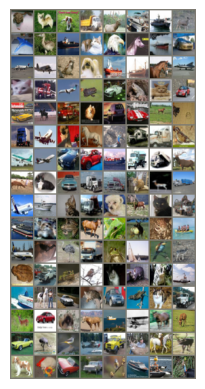

Noisy labels (row 0):  bird  deer  car   cat   bird  cat   horse frog 
Noisy labels (row 1):  bird  truck cat   plane truck car   horse ship 
Noisy labels (row 2):  frog  dog   cat   truck dog   bird  truck horse
Noisy labels (row 3):  dog   bird  deer  ship  deer  car   bird  bird 
Noisy labels (row 4):  deer  bird  plane ship  bird  plane truck car  
Noisy labels (row 5):  plane truck plane truck plane plane bird  ship 
Noisy labels (row 6):  horse car   frog  cat   dog   cat   horse plane
Noisy labels (row 7):  truck car   bird  frog  bird  truck plane dog  
Noisy labels (row 8):  bird  car   dog   deer  frog  frog  frog  cat  
Noisy labels (row 9):  frog  horse car   plane car   frog  deer  bird 
Noisy labels (row 10):  car   ship  cat   dog   plane deer  cat   dog  
Noisy labels (row 11):  deer  deer  deer  cat   deer  deer  dog   car  
Noisy labels (row 12):  frog  ship  horse frog  ship  plane ship  deer 
Noisy labels (row 13):  plane deer  car   frog  plane deer  car   bird 
No

In [58]:
imshow(torchvision.utils.make_grid(noise_images))
for i in range(0, len(noisey_labels), 8):
    print(
        f"Noisy labels (row {i//8}): ",
        " ".join(f"{classes[noisey_labels[i+j]]:5s}" for j in range(8)),
    )

### Training MLPs and ConvNets on the noisy datasets

In [59]:
# TODO: 5 points -- Train your best MLP and check the training accuracy
loss_module: nn.Module = nn.CrossEntropyLoss()

model_mlp = MLP(**mlp_best_configuration).to(device)
optimizer = SGDMomentum(model_mlp.parameters(), lr=mlp_train_best_configuration["lr"])
model_mlp.print_configuration()
model_name = "myMLP_NoisyDataset"
model_mlp = train_model(
    model_mlp,
    optimizer,
    loss_module,
    noise_train_loader,
    val_loader,
    num_epochs=mlp_train_best_configuration["num_epochs"],
    model_name=model_name,
    plot_confusion_mat=False,
    lr_epoch_map=mlp_train_best_configuration["lr_epoch_map"],
)
test_acc, _ = test_model(model_mlp, test_loader)
print(f"Test accuracy: {test_acc*100.0:05.2f}%\n\n")

Number of parameters: 3.841M
Number of Hidden Dimensions: 4
	[1024, 512, 256, 128]
Activation Function: '<class 'torch.nn.modules.activation.Hardswish'>'
Dropout: False
BatchNorm: True

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 10.81%, Validation accuracy: 02.24%, Best validation accuracy: 02.24%
Mismatched shape for confusion matrix: '(10, 10)' vs '(9, 9)'
[Epoch 10] Training accuracy: 10.73%, Validation accuracy: 01.68%, Best validation accuracy: 02.24%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 15] Training accuracy: 10.94%, Validation accuracy: 01.48%, Best validation accuracy: 02.24%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 20] Training accuracy: 11.07%, Validation accuracy: 01.46%, Best validation accuracy: 02.24%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 25] Training accuracy: 10.82%, Validation accuracy: 01.44%, Best validation accuracy: 02.24%
Mism

In [60]:
# TODO: 5 points -- Train your best ConvNet and check the training accuracy
data_transforms_ = default_augmentations_torchvision()
main_dataset__ = CIFAR10(root=DATASET_PATH, train=True, transform=data_transforms_, download=True)
noisy_train_set_, _ = torch.utils.data.random_split(main_dataset__, [45000, 5000], generator=torch.Generator().manual_seed(seed))
noise_train_dataset_ = NoisyDataset(noisy_train_set_, seed)

# Create data loaders for later
noise_train_loader_ = data.DataLoader(
    noise_train_dataset_,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=3,
)

loss_module = nn.CrossEntropyLoss().to(device)

model_convnet = ConvNet(**convnet_best_configuration).to(device)
optimizer = SGDMomentum(model_convnet.parameters(), lr=convnet_train_best_configuration["lr"])
model_convnet.print_configuration()
model_name = "myCNN_NoisyDataset"
model_convnet = train_model(
    model_convnet,
    optimizer,
    loss_module,
    noise_train_loader_,
    val_loader_,
    num_epochs=convnet_train_best_configuration["num_epochs"],
    model_name=model_name,
    plot_confusion_mat=False,
    lr_epoch_map=convnet_train_best_configuration["lr_epoch_map"],
)
test_acc, _ = test_model(model_convnet, test_loader_)
print(f"Test accuracy: {test_acc*100.0:05.2f}%\n\n")

Files already downloaded and verified
Model:
	Parameters: 0.338M
	Activation Layer: <class 'torch.nn.modules.activation.ReLU'>
	Conv Hidden Dims: [90, 120]
	Conv Kernel Sizes: [3, 5]
	Conv Maxpool Kernel Sizes: [3, 3]
	MLP Input Size: 120
	MLP Hidden Dims: [256, 128]

MLP Configuration:
Number of parameters: 0.065M
Number of Hidden Dimensions: 2
	[256, 128]
Activation Function: '<class 'torch.nn.modules.activation.ReLU'>'
Dropout: False
BatchNorm: False

Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch  5] Training accuracy: 10.87%, Validation accuracy: 02.40%, Best validation accuracy: 02.40%
Mismatched shape for confusion matrix: '(10, 10)' vs '(8, 8)'
[Epoch 10] Training accuracy: 10.83%, Validation accuracy: 01.40%, Best validation accuracy: 02.40%
Mismatched shape for confusion matrix: '(10, 10)' vs '(7, 7)'
[Epoch 15] Training accuracy: 10.81%, Validation accuracy: 01.04%, Best validation accuracy: 02.40%
Mismatched shape for confusion matrix: '(10, 10)' vs '(

**We can see that in both models, MLP & CNN + FCN, there is not much fitting to noise occuring during training. Both models trained with the best configuration we improved upon earlier had a testing accuracy less than 3%.**

## Conclusion

You have reached the end of the practical, congratulations! Now, you should have a good idea of what it means to train a MLP, how we can use neural networks to perform image classification, what aspects there are to improve a networks performance, and what limitations and risks there are. 